## This notebook is going to be a cleaner version of the satellite finding for the full PDR region

In [1]:
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy import units as u
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'stixgeneral'
%matplotlib inline
#matplotlib.matplotlib_fname()
#import linetools.utils as ltu
from astropy.coordinates import Angle
from astropy.coordinates import SkyCoord
import copy
from colossus.halo import profile_nfw
%config InlineBackend.figure_format = 'retina'

In [2]:
# read in the data
data_pth = '/Users/astro/Desktop/GitHub/satellite_fraction/data/'
data_file = data_pth + 's16a_massive_logmMax_11.45_z_0.25_0.47_mhalo_pdr_full.fits'

hdu1 = fits.open(data_file)
data_table = Table(hdu1[1].data)

In [3]:
# set cosmology params
import colossus
from colossus.cosmology import cosmology
params = {'flat': True , 'H0': 70.0 , 'Om0': 0.3 , 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.95}
h = .7
cosmology.addCosmology('huang18',params)
cosmology.setCosmology('huang18')
from colossus.halo import mass_so

In [4]:
pdr_use = Table(names = data_table.colnames)

for i in range(len(np.array(data_table['logm_max']))):
    if data_table['logm_max'][i] > 11.5 and data_table['z_best'][i] > .25 and data_table['z_best'][i] < .45:
        pdr_use.add_row(data_table[i])

In [5]:
# Now to find r_halo
r_halo = mass_so.M_to_R((10**pdr_use['logmh_vir'])*h , pdr_use['z_best'], 'vir')/h # kpc

# Turn the physical radius into an angular size in degrees
theta_per_kpc = FlatLambdaCDM(H0=70 , Om0= 0.3).arcsec_per_kpc_proper(pdr_use['z_best'])
r_halo_deg = ((r_halo*u.kpc * theta_per_kpc).to(u.deg))/u.deg

In [6]:
# put the array data into a new table
pdr_use['r_halo'] = r_halo_deg
pdr_use.sort('logm_max')

# bins before reversing table
mass_bins = [11.5, 11.6, 11.7, 11.8, 11.9, 12.0, 12.1, 12.2, 12.3]
pdr_use.reverse() # rank order by mass

In [7]:
pdr_use

object_id,ra,dec,z_spec,z_best,z_phot,z_type,gcmodel_mag,gcmodel_mag_err,rcmodel_mag,rcmodel_mag_err,icmodel_mag,icmodel_mag_err,zcmodel_mag,zcmodel_mag_err,ycmodel_mag,ycmodel_mag_err,MSTAR,logm_10,logm_30,logm_100,logm_max,vdisp_sdss,vdisp_err_sdss,logms_gama,logms_err_gama,id_cluster_redm,p_mem_redm,z_lambda_redm,lambda_redm,p_cen_1_redm,id_camira,z_camira,n_cor_camira,logms_camira,r50_max,r50_100,logmh_peak,logmh_vir,logmh_host,ra_pdr,dec_pdr,sep_arcsec_pdr,r_halo
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
3.855398009099619e+16,35.44059252413666,-3.7718939803811065,0.43314000964164734,0.43314000964164734,nan,3.0,20.731653213500977,0.0038585804868489504,19.158721923828125,0.002081499667838216,18.503089904785156,0.0007950778235681355,18.00079917907715,0.0012355220969766378,17.759296417236328,0.0017704503843560815,11.647004127502441,11.400324089091573,11.779539671220244,12.086735913783315,12.251829628357296,262.61456298828125,42.48577880859375,nan,nan,3502.0,1.0,0.4354531466960907,64.38020324707031,0.8623663783073425,679.0,0.4296000003814697,69.25299835205078,12.79699993133545,57.24333943232699,30.685047882601168,14.85454893581295,14.85454893581295,14.85454893581295,35.44059252413666,-3.7718939803811735,2.404499339186419e-10,0.08924687835365963
4.110925370389125e+16,179.04505668361824,-0.3502257880520267,0.2563000023365021,0.2563000023365021,nan,3.0,18.64087677001953,0.0010620745597407222,17.262283325195312,0.0004805444914381951,16.686813354492188,0.00035636068787425756,16.35328483581543,0.000480467191664502,16.05872344970703,0.0006164101068861783,11.84264850616455,11.56609568738403,11.928837205160757,12.124902712847133,12.160188328627656,337.2088928222656,14.350641250610352,11.930765229545877,0.10168382419281555,668.0,1.0,0.26775580644607544,66.39385986328125,0.9969436526298523,-9999.0,nan,nan,nan,23.392730787795507,20.85574700627102,14.343999069057162,14.343999069057162,14.343999069057162,179.04505668361824,-0.35022578805203286,2.218436890320803e-11,0.09410854134272494
4.205028533341357e+16,136.24599160481256,0.6456194104784296,0.4012399911880493,0.4012399911880493,nan,3.0,20.386423110961914,0.0024124085903167725,18.568134307861328,0.0008086112793534994,17.90260887145996,0.0005270538968034089,17.53518295288086,0.0005775167956016958,17.27908706665039,0.0007605889113619924,11.826018333435059,11.54225916583996,11.853499564961277,12.072650696596012,12.123995299075329,365.6456604003906,35.0802116394043,11.877827367880625,0.11594394279103333,-9999.0,nan,nan,nan,nan,-9999.0,nan,nan,nan,26.45460866323491,21.687272944608356,14.40925665203891,14.40925665203891,14.40925665203891,136.2459917024095,0.6456193760592552,0.0003725370319886118,0.06752384988723344
4.310168473752755e+16,130.59117550760237,1.6406693222659239,0.419950008392334,0.419950008392334,nan,3.0,20.727100372314453,0.00336706405505538,18.982797622680664,0.0013615167699754238,18.272830963134766,0.000858254381455481,17.8691349029541,0.0009827454341575503,17.65071678161621,0.0013621409889310598,11.725220680236816,11.362146139777161,11.7390989630734,11.973318525502462,12.110200648005456,256.6693420410156,18.655799865722656,11.950526729232926,0.17195254961138473,854.0,1.0,0.38627371191978455,102.3650894165039,0.9714469313621521,1200.0,0.4244999885559082,82.09600067138672,12.935999870300293,40.15641708762019,23.707532187031127,14.806790271584067,14.806790271584067,14.806790271584067,130.59117550760237,1.6406693222659525,1.0304997167941794e-10,0.08824047068097621
4.228763811109603e+16,216.43868579136853,0.38897403751849646,0.326119989156723,0.326119989156723,nan,3.0,19.738039016723633,0.0012289888691157103,18.260906219482422,0.000551

In [58]:
# actual satellite finding
import satellite_finder as sf
mass_center_004, frac_sat_004, err_004 = sf.run_pdr_satellite(pdr_use, .004, mass_bins)
#mass_center_006, frac_sat_006, err_006 = sf.run_pdr_satellite(cat_table, .006, 20)
#mass_center_008, frac_sat_008, err_008 = sf.run_pdr_satellite(cat_table, .008, 20)
#mass_center_02, frac_sat_02, err_02 = sf.run_pdr_satellite(cat_table, .02, 20)
#mass_center_04, frac_sat_04, err_04 = sf.run_pdr_satellite(pdr_use, .04, mass_bins)
#mass_center_041, frac_sat_041, err_041 = sf.run_pdr_satellite(cat_table, .041, 20)

Text(0.5,1,'PDR Satellite Fraction')

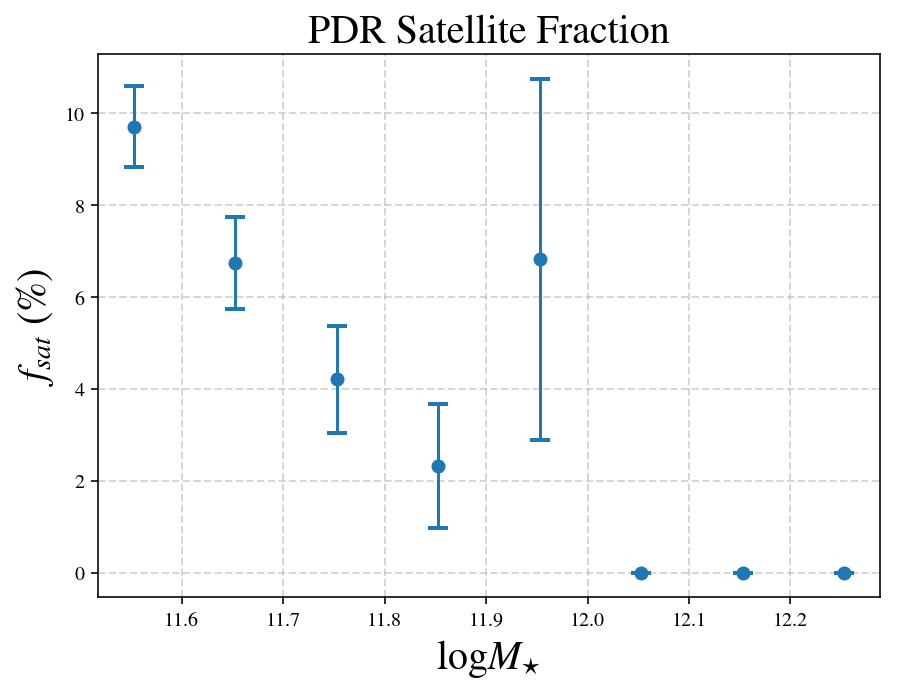

In [43]:
fig = plt.figure(figsize=(7,5))


ax1 = fig.add_subplot(111)
ax1.grid(linewidth=1, linestyle='--', alpha=0.5)

ax1.errorbar(mass_center_004, frac_sat_004, err_004, fmt='o',capthick=2, capsize=5, label = '$dz = \pm 0.004$')
#ax1.errorbar(mass_center_006, frac_sat_006, err_006, fmt='o',capthick=2, capsize=5, label = '$dz = \pm 0.006$')
#ax1.errorbar(mass_center_008, frac_sat_008, err_008, fmt='o',capthick=2, capsize=5, label = '$dz = \pm 0.008$')
#ax1.errorbar(mass_center_02, frac_sat_02, err_02, fmt='o',capthick=2, capsize=5, label = '$dz = \pm 0.02$')
#ax1.errorbar(mass_center_04, frac_sat_04, err_04, fmt='o',capthick=2, capsize=5, label = '$\Delta z = \pm 0.05$')
#ax1.errorbar(mass_center_041, frac_sat_041, err_041, fmt='o',capthick=2, capsize=5, label = '$dz = \pm 0.041$')


ax1.set_xlabel(r'$ \log M_{\star}$', fontsize=20)
ax1.set_ylabel(r'$ f_{sat}$ ($\%$)', fontsize=20)
ax1.set_title('PDR Satellite Fraction', fontsize = 20)
#plt.savefig('pdr_satellite_fraction.png', dpi = 1000)

### Now I will look at the PDR and Model Satellite Fraction side-by-side

In [44]:
model = data_pth + 'um_smdpl_model_logms_tot_11.4.fits'
hdu1 = fits.open(model)

# create astropy table of useful data
model_table = Table()
model_table['logms_tot_mod'] = hdu1[1].data['logms_tot_mod']
model_table['upid'] = hdu1[1].data['upid']
model_table.sort('logms_tot_mod')

centrals_mod = []
sats_mod = []

for i in range(27241):
    if model_table['upid'][i] == -1:
        centrals_mod.append(model_table['logms_tot_mod'][i])
    else:
        sats_mod.append(model_table['logms_tot_mod'][i])    
# range of masses
mmin = np.min(model_table['logms_tot_mod'])
mmax = np.max(model_table['logms_tot_mod'])


hist_all, edges_all = np.histogram(pdr_use['logm_max'], bins = mass_bins)

# from Song's satellite finding code  
hist_all_mod, edges_all_mod = np.histogram(model_table['logms_tot_mod'], bins=edges_all)
hist_cen_mod, edges_cen_mod = np.histogram(centrals_mod, bins=edges_all)
hist_sat_mod, edges_sat_mod = np.histogram(sats_mod, bins=edges_all)

mass_center_mod = np.log10((10**edges_cen_mod[1:] + 10**edges_cen_mod[:-1]) / 2)
 
frac_sat_mod = (hist_sat_mod / hist_all_mod) * 100

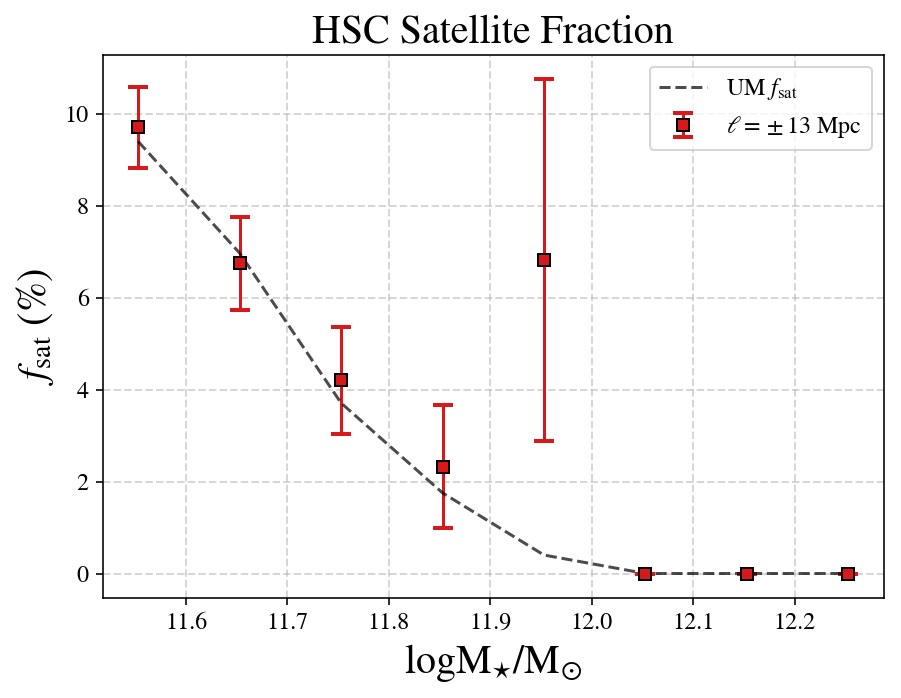

In [45]:
fig = plt.figure(figsize=(7,5))


ax1 = fig.add_subplot(111)
ax1.grid(linewidth=1, linestyle='--', alpha=0.5)


ax1.errorbar(mass_center_004, frac_sat_004, err_004, color = '#d7191c',fmt='s',mec = 'k',capthick=2, capsize=5, label = '$\ell = \pm 13$ Mpc')
ax1.plot(mass_center_mod, frac_sat_mod, ls = '--', color = 'k',alpha = 0.7, label = 'UM $f_{\mathrm{sat}}$')

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)



ax1.set_xlabel(r'$ \log \mathrm{M_{\star} / M_{\odot}}$', fontsize=20)
ax1.set_ylabel(r'$f_{\mathrm{sat}}$ (%)', fontsize=20)
ax1.set_title('HSC Satellite Fraction', fontsize = 20)
ax1.legend(fontsize = 12)
plt.savefig('pdr_satellite_fraction.png', dpi = 1000)

* For reference, I want to shade the space between the curves as a region where the fsat curves can exist.

In [12]:
Mean_logM =  [11.454280124360066, 11.578713361036991, 11.701840449447248, 11.827196417870741, 11.951702092177047]
frac_sat =  np.array([13.49764457 , 9.16328442 , 5.41699143 , 1.63398693 , 0.33557047])
frac_sat_low =  np.array([12.57567781 , 8.42428901 , 4.48395825 , 0.87241003 , 0.])
frac_sat_high =  np.array([15.32788663, 10.66708132 , 6.38379205 , 3.04518664 , 1.08401084])

err_high = frac_sat_high - frac_sat
err_low = frac_sat - frac_sat_low

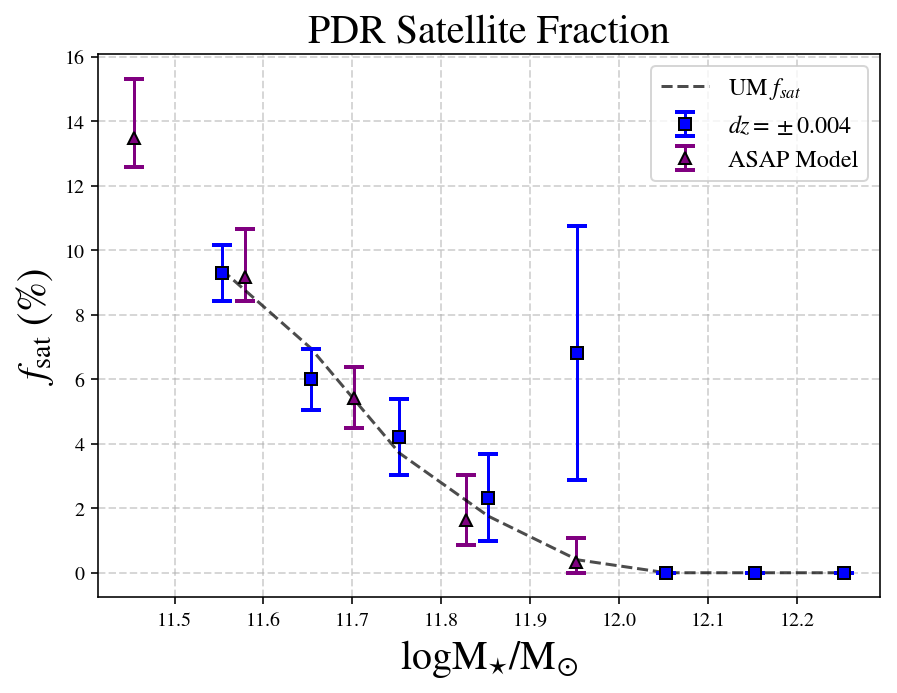

In [41]:
fig = plt.figure(figsize=(7,5))


ax1 = fig.add_subplot(111)
ax1.grid(linewidth=1, linestyle='--', alpha=0.5)

ax1.plot(mass_center_mod, frac_sat_mod, ls = '--', color = 'k',alpha = 0.7, label = 'UM $f_{sat}$')
ax1.errorbar(mass_center_004, frac_sat_004, err_004, color = 'blue',mec = 'k', fmt='s',capthick=2, capsize=5, label = '$dz = \pm 0.004$')
#ax1.errorbar(mass_center_04, frac_sat_04, err_04, color = 'firebrick',mec = 'k',fmt='s',capthick=2, capsize=5, label = '$\ell = \pm 140$ Mpc')
#ax1.fill_between(mass_center_004[0:4], frac_sat_004[0:4], frac_sat_04[0:4], color = 'gray')

ax1.errorbar(Mean_logM, frac_sat, (err_low, err_high), color = 'purple', mec = 'k', fmt='^',capthick=2, capsize=5, label = 'ASAP Model')


ax1.set_xlabel(r'$ \log \mathrm{ M_{\star} / M_{\odot} }$', fontsize=20)
ax1.set_ylabel(r'$ f_{\mathrm{sat}}$ (%)', fontsize=20)
ax1.set_title('PDR Satellite Fraction', fontsize = 20)
ax1.legend(fontsize = 12)

plt.savefig('pdr_ASAP_satellite_fraction.eps', dpi = 1000)

# Bootstrapping

The next order of business is to use some more formal error bars. The way I will do this for now is by resampling and running numerous trials. Later, we may look at uncertainty in M$_{\star \rm tot}$

In [50]:
# start by identifying basic parameters
sample_size = 2405 # number of galaxies (minus one because python)
iterations = range(100)

In [53]:
fsat_trials = []
# now actually bootstrapping
for i in iterations:
    trial_sample = Table(names = pdr_use.colnames)
    trial_indices = np.random.randint(0, sample_size, size = sample_size)
    for j in range(len(trial_indices)):
        trial_sample.add_row(pdr_use[trial_indices[j]])
    trial_sample.sort('logm_max')    
    trial_sample.reverse()
    fsat_trials.append(sf.run_pdr_satellite(trial_sample, 0.004, mass_bins)[1])
    print('trial', i, 'done')
# need to find the standard deviation of the results
np.std(fsat_trials, axis = 0)

trial 0 done
trial 1 done
trial 2 done
trial 3 done
trial 4 done
trial 5 done
trial 6 done
trial 7 done
trial 8 done
trial 9 done
trial 10 done
trial 11 done
trial 12 done
trial 13 done
trial 14 done
trial 15 done
trial 16 done
trial 17 done
trial 18 done
trial 19 done
trial 20 done
trial 21 done
trial 22 done
trial 23 done
trial 24 done
trial 25 done
trial 26 done
trial 27 done
trial 28 done
trial 29 done
trial 30 done
trial 31 done
trial 32 done
trial 33 done
trial 34 done
trial 35 done
trial 36 done
trial 37 done
trial 38 done
trial 39 done
trial 40 done
trial 41 done
trial 42 done
trial 43 done
trial 44 done
trial 45 done
trial 46 done
trial 47 done
trial 48 done
trial 49 done
trial 50 done
trial 51 done
trial 52 done
trial 53 done
trial 54 done
trial 55 done
trial 56 done
trial 57 done
trial 58 done
trial 59 done
trial 60 done
trial 61 done
trial 62 done
trial 63 done
trial 64 done
trial 65 done
trial 66 done
trial 67 done
trial 68 done
trial 69 done
trial 70 done
trial 71 done
tr

array([0.80561073, 0.91367643, 1.03015114, 1.28974382, 3.0610956 ,
       0.        , 0.        , 0.        ])

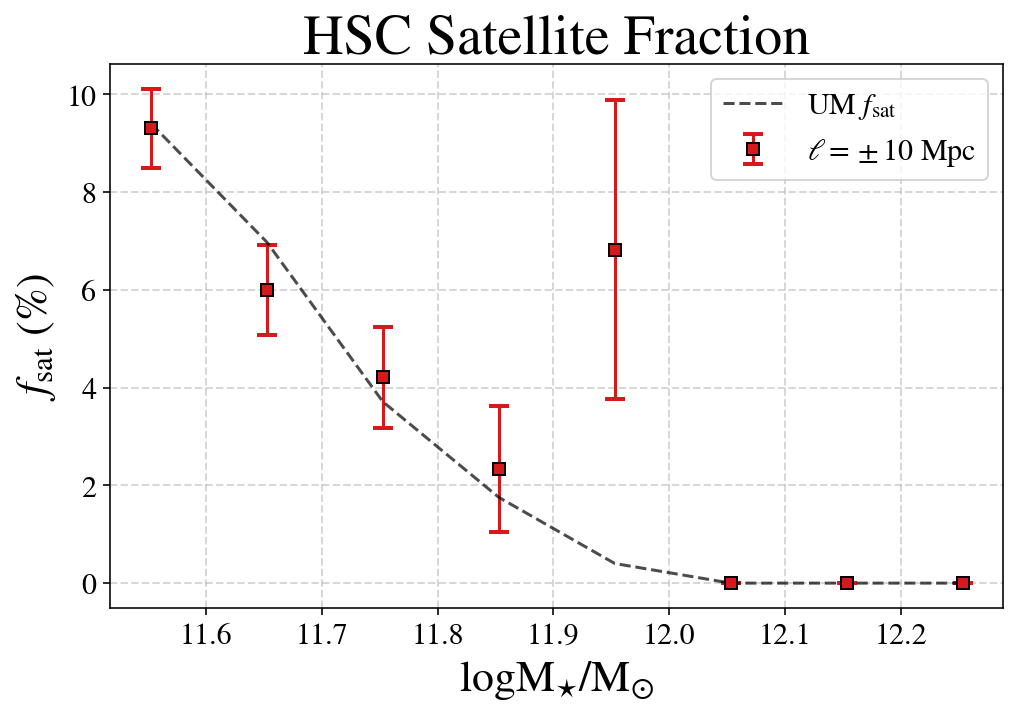

In [65]:
fig = plt.figure(figsize=(8,5))


ax1 = fig.add_subplot(111)
ax1.grid(linewidth=1, linestyle='--', alpha=0.5)


ax1.errorbar(mass_center_004, frac_sat_004, np.std(fsat_trials, axis = 0), color = '#d7191c',fmt='s',mec = 'k',capthick=2, capsize=5, label = '$\ell = \pm 10$ Mpc')
ax1.plot(mass_center_mod, frac_sat_mod, ls = '--', color = 'k',alpha = 0.7, label = 'UM $f_{\mathrm{sat}}$')
#for i in range(len(fsat_trials)):
    #ax1.plot(mass_center_04, fsat_trials[i], c = 'gray', linewidth = 1, alpha = 0.7)
    
    
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)



ax1.set_xlabel(r'$ \log \mathrm{M_{\star} / M_{\odot}}$', fontsize=22)
ax1.set_ylabel(r'$f_{\mathrm{sat}}$ (%)', fontsize=22)
ax1.set_title('HSC Satellite Fraction', fontsize = 28)
ax1.legend(fontsize = 15)
plt.savefig('pdr_satellite_fraction.png', dpi = 1000)